In [6]:
from typing import Dict
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

In [7]:
# import pickle

# with open('data/optimisation_model_rottne_data.pkl', 'rb') as f: 
#     optimisation_data, projection_point_risk = pickle.load(f)

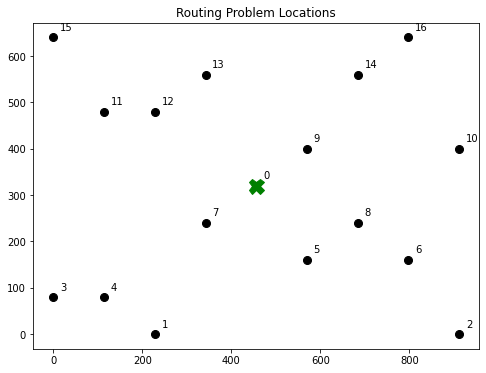

In [8]:
coordinates = [
    (456, 320), # location 0 - the depot
    (228, 0),    # location 1
    (912, 0),    # location 2
    (0, 80),     # location 3
    (114, 80),   # location 4
    (570, 160),  # location 5
    (798, 160),  # location 6
    (342, 240),  # location 7
    (684, 240),  # location 8
    (570, 400),  # location 9
    (912, 400),  # location 10
    (114, 480),  # location 11
    (228, 480),  # location 12
    (342, 560),  # location 13
    (684, 560),  # location 14
    (0, 640),    # location 15
    (798, 640)]  # location 16

X = np.array([x[0] for x in coordinates])
Y = np.array([x[1] for x in coordinates])

f, ax = plt.subplots(figsize = [8,6])
for i, txt in enumerate(coordinates):
    ax.text(X[i] + 15, Y[i]+ 15, f"{i}")

ax.plot(X, Y, 'ko', markersize=8)
ax.plot(X[0], Y[0], 'gX', markersize=15)
ax.set_title("Routing Problem Locations")
plt.show()

In [9]:
from ortools.linear_solver import pywraplp
from ortools.sat.python import cp_model

In [124]:
# simulate data

distance = [
        [
            0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354,
            468, 776, 662
        ],
        [
            548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674,
            1016, 868, 1210
        ],
        [
            776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164,
            1130, 788, 1552, 754
        ],
        [
            696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822,
            1164, 560, 1358
        ],
        [
            582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708,
            1050, 674, 1244
        ],
        [
            274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628,
            514, 1050, 708
        ],
        [
            502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856,
            514, 1278, 480
        ],
        [
            194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320,
            662, 742, 856
        ],
        [
            308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662,
            320, 1084, 514
        ],
        [
            194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388,
            274, 810, 468
        ],
        [
            536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764,
            730, 388, 1152, 354
        ],
        [
            502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114,
            308, 650, 274, 844
        ],
        [
            388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194,
            536, 388, 730
        ],
        [
            354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0,
            342, 422, 536
        ],
        [
            468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536,
            342, 0, 764, 194
        ],
        [
            776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274,
            388, 422, 764, 0, 798
        ],
        [
            662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730,
            536, 194, 798, 0
        ],
    ]

np.random.seed(123)
node_weights = np.arange(1,18)*10
np.random.shuffle(node_weights)
node_weights[0] = 0

n_vehicles = 3
all_vehicles = range(n_vehicles)
all_nodes = range(len(distance))
all_nodes_without_depot = range(1, len(distance))
num_nodes = len(all_nodes)
min_vehicles_workload=300
max_vehicles_worktime=2000
node_weights

array([  0, 100, 170,  90,  60,  80,  10, 110, 120,  40,  20,  70, 160,
       130,  30, 150, 140])

In [125]:
#model = pywraplp.Solver.CreateSolver('CP-SAT')
#model.EnableOutput()
#solver_name = 'GUROBI_MIP'
#model = pywraplp.Solver.CreateSolver(solver_name)
#model.EnableOutput()
model = cp_model.CpModel()


In [126]:
x = {}
d = {}
u = {}

for v in all_vehicles:
    for i in all_nodes:
        d[(v,i)] = model.NewIntVar(-1,3,'d_v%ii%i' % (v, i))
        for j in all_nodes:
            #x[(v, i, j)] = model.NewBoolVar('x_v%ii%ij%i' % (v, i, j))
            x[(v, i, j)] = model.NewIntVar(0,1,'x_v%ii%ij%i' % (v, i, j))
            


In [127]:
# constraint 1: leave every point exactly once

for i in all_nodes_without_depot:
    model.Add(sum(x[(v, i, j)] for j in all_nodes for v in all_vehicles) <= 1)

# constraint 1: reach every point exactly once
for j in all_nodes_without_depot:
    model.Add(sum(x[(v, i, j)] for i in all_nodes for v in all_vehicles) <= 1)


for v in all_vehicles: 
    for i in all_nodes:
            model.AddAbsEquality(d[(v,i)], sum(x[(v, i, j)] for j in all_nodes )+
                        sum(x[(v, j, i)] for j in all_nodes )-1)
            model.Add(d[(v,i)]==1)
            model.Add( sum(x[(v, i, j)] for j in all_nodes )<=1)
            model.Add( sum(x[(v, j, i)] for j in all_nodes )<=1)
            
# constraint 2: every depot must be visited two times by each vehicle
# leave
for v in all_vehicles:
    model.Add(sum(x[(v, 0, j)] for j in all_nodes_without_depot) == 1)
# reach
for v in all_vehicles:
    model.Add(sum(x[(v, i, 0)] for i in all_nodes_without_depot) == 1)

# constraint 3: outbound and inbound of every depot must be different
for v in all_vehicles: 
    for i in all_nodes_without_depot:
        model.Add((x[(v, i, 0)] +  x[(v, 0, i)]) <= 1)
        
for v in all_vehicles:
    model.Add(sum([x[(v, i, i) ] for  i in all_nodes]) == 0)

# constraint 3: subtour elimination constraints

for v in all_vehicles:
    for i in all_nodes:
        u[v,i] = model.NewIntVar(0, num_nodes, 'u_v%ii%i' % (v,i))

for v in all_vehicles:
    model.Add(u[v,0] == 1)

for v in all_vehicles:
    for i in all_nodes_without_depot:
        model.Add(u[v,i] >= 2)
        model.Add(u[v,i] <= num_nodes)

for v in all_vehicles:
    for i in all_nodes_without_depot:
        for j in all_nodes_without_depot:
            model.Add(u[v,i] - u[v,j] + 1 <= (num_nodes - 1)*(1-x[v,i,j]))

# constraint 4: vehicle max worktime

for v in all_vehicles:
    model.Add(sum(x[(v,i,j)]*distance[i][j]+(x[(v,i,j)]*node_weights[i]) for i in all_nodes for j in all_nodes) < max_vehicles_worktime)

# constraint 5: vehicle min workload

for v in all_vehicles:
    model.Add(sum(x[(v,i,j)]*distance[i][j]+(x[(v,i,j)]*node_weights[i]) for i in all_nodes for j in all_nodes) > min_vehicles_workload)



In [128]:
# Minimize the total distance
model.Maximize(sum(x[(v,i,j)]*node_weights[i] for v in all_vehicles for i in all_nodes for j in all_nodes ))


solver = cp_model.CpSolver()
solver.parameters.linearization_level = 0
solver.parameters.max_time_in_seconds = 30
solver.parameters.num_search_workers = 4
status = solver.Solve(model)

solver.StatusName()

'FEASIBLE'

In [129]:
total = np.zeros(n_vehicles)
for v in all_vehicles:
    for i in all_nodes:
        for j in all_nodes:
            if solver.BooleanValue(x[v,i,j]):
                total[v] += distance[i][j]
                print(f"{v}_{i}_{j}: {solver.Value(x[v,i,j])}; distance: {distance[i][j]} ;")

0_0_4: 1; distance: 582 ;
0_1_7: 1; distance: 354 ;
0_3_1: 1; distance: 308 ;
0_4_3: 1; distance: 114 ;
0_7_0: 1; distance: 194 ;
1_0_13: 1; distance: 354 ;
1_12_0: 1; distance: 388 ;
1_13_15: 1; distance: 422 ;
1_15_12: 1; distance: 388 ;
2_0_8: 1; distance: 308 ;
2_2_5: 1; distance: 502 ;
2_5_0: 1; distance: 274 ;
2_6_2: 1; distance: 274 ;
2_8_6: 1; distance: 194 ;


In [118]:
total

array([1712., 1872., 1872.])

In [119]:
solver.ObjectiveValue()

133.0

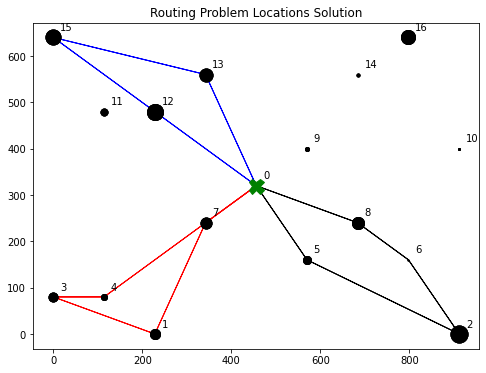

In [130]:
X = np.array([x[0] for x in coordinates])
Y = np.array([x[1] for x in coordinates])

f, ax = plt.subplots(figsize = [8,6])
for i, txt in enumerate(coordinates):
    ax.text(X[i] + 15, Y[i]+ 15, f"{i}")

markersizes=node_weights/10

ax.plot(X[0], Y[0], 'gX', markersize=15)
cols = ["red","blue","black"]
for v in all_vehicles:
    for i in all_nodes:
        ax.plot(X[i], Y[i], 'ko', markersize=markersizes[i])
        for j in all_nodes:
            if solver.BooleanValue(x[v,i,j]):
                ax.arrow(X[i],Y[i],X[j]-X[i],Y[j]-Y[i],color=cols[v])
ax.set_title("Routing Problem Locations Solution")
plt.show()

In [99]:
markersizes

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160])

In [1527]:
def create_data_model(projection_point_risk: pd.Series,
                      optimisation_data: Dict) -> Dict:
    """Stores the data for the problem."""
    data = {}
    data['num_vehicles'] = 13
    data['vehicle_max_capacities'] = [100] * data['num_vehicles'] # 2 weeks = 10 hours/day * 10 days
    data['vehicle_min_capacities'] = [50] * data['num_vehicles'] # 1 weeks = 10 hours/day * 5 days
    data['all_vehicles'] = range(data['num_vehicles'])
    projection_point_risk.index = projection_point_risk.index + 1
    data['all_nodes'] = projection_point_risk.index.tolist()
    data['node_risks']= projection_point_risk.to_dict()
    data['node_times']= optimisation_data['node']['time']
    data['node_costs']= optimisation_data['node']['cost']
    data['edge_costs']= optimisation_data['edge']['cost']
    data['edge_times']= optimisation_data['edge']['time']
    weight_factor = 2
    data['values'] = {i: data['node_risks'][i]- weight_factor * data['node_costs'][i] for i in data['all_nodes']} 
    
    return data

In [17]:
projection_point_risk

projection_point_index
959              NaN
960              NaN
961              NaN
962              NaN
963              NaN
            ...     
2104    2.378687e+06
2105    4.571429e+06
2106    2.955196e+06
2107    7.928803e+06
2108    5.541348e+05
Length: 778, dtype: float64

In [4]:
data = create_data_model(projection_point_risk, optimisation_data)

In [5]:
data['all_nodes'] = data['all_nodes'][50:150]

In [6]:
solver = pywraplp.Solver.CreateSolver('CBC')

In [7]:
#

x = {}

for i in data['all_nodes']:
    for b in data['all_vehicles']:
        x[i, b] = solver.BoolVar(f'x_{i}_{b}')
        
# Constraints.
# Each edge is assigned to at most one vehicle.

for i in data['all_nodes']:
    solver.Add(sum(x[i, b] for b in data['all_vehicles']) <= 1)

# The depot must be visited by each vehicle.

# Each vehicle's traveling time must exceed its min contraint 1 weeks.
# Each vehicle's traveling time cannot exceed its max contraint 2 weeks.
for b in data['all_vehicles']:
    traveling_time = 0
    traveling_time_list = []
    for i in data['all_nodes']:
        for j in data['all_nodes']:
            traveling_time_list.append(x[i, b] * x[j, b] * data['edge_times'][i,j])
            
    traveling_time = sum(traveling_time_list)    
    clearing_time =  sum(x[i, b] * data['node_times'][i] for i in data['all_nodes'])  
    
    time_per_vehicle = clearing_time  + traveling_time

    solver.Add(time_per_vehicle >= data['vehicle_min_capacities'][b])

    solver.Add(time_per_vehicle <= data['vehicle_max_capacities'][b])

    
# Objective
# Maximize total risk

objective = solver.Objective()
for i in data['all_nodes']:
    for b in data['all_vehicles']:
        objective.SetCoefficient(x[i, b], data['values'][i])
            
objective.SetMaximization()

        
status = solver.Solve()

In [8]:
objective.Value()

0.0

In [ ]:
if status == pywraplp.Solver.OPTIMAL:
    print(f'Total risk value: {objective.Value()}')
    total_risk = 0
    for b in data['all_vehicles']:
        print(f'Vehicle {b}')
        vehicle_risk = 0
        for i in data['all_nodes']:
            if x[i, b].solution_value() > 0:
                print(
                    f"Node {i} risk: {data['node_risks'][i]}"
                )
                vehicle_risk += data['node_risks'][i]
        print(f'Vehicles risk: {vehicle_risk}')

        total_risk += vehicle_risk
    print(f'Total risk value: {total_risk}')
else:
    print('The problem does not have an optimal solution.')